In [1]:
import pandas as pd
import itertools
import firebase_admin
import os 
import vertexai
import random
import time
import logging
import re
import math
import matplotlib.pyplot as plt
from google.cloud import storage, texttospeech
from PIL import Image
from firebase_admin import credentials, firestore
from hashlib import sha256
from vertexai.preview.generative_models import GenerationConfig
from vertexai.preview.vision_models import ImageGenerationModel
from vertexai.generative_models import GenerativeModel, ChatSession
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Constants from environment variables
PROJECT_ID = os.getenv("PROJECT_ID")
LOCATION = os.getenv("LOCATION", "asia-southeast1")
FIREBASE_CRED_PATH = os.getenv("FIREBASE_CRED_PATH")
LOG_FILE_PATH = os.getenv("LOG_FILE_PATH", "ad_generator.log")

# Initialize Vertex AI with the specified project and location
vertexai.init(project=PROJECT_ID, location=LOCATION)

# Configure basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', filename=LOG_FILE_PATH, filemode='a')

# Initialize Firebase Admin
cred = credentials.Certificate(FIREBASE_CRED_PATH)
firebase_admin.initialize_app(cred)

def extract_thai_text(text: str) -> str:
    """Extracts Thai characters from text using a regex pattern."""
    thai_pattern = re.compile("[ก-๙]+")
    thai_matches = thai_pattern.findall(text)
    return ' '.join(thai_matches)

def ensure_local_path_exists(local_path: str) -> None:
    """Ensures the directory for the local_path exists."""
    directory = os.path.dirname(local_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def resize_image(input_path: str, output_path: str, new_width: int, new_height: int) -> None:
    """Resizes an image to the specified dimensions and saves it."""
    with Image.open(input_path) as img:
        resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        resized_img.save(output_path)

def display_images_in_grid(images) -> None:
    """Displays a grid of images and saves them to a randomly named file."""
    nrows = math.ceil(len(images) / 4)
    ncols = min(len(images) + 1, 4)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i]._pil_image)
            ax.set_aspect("equal")
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

In [4]:
class AdGenerator:
    """Generates advertisement content including texts and images for products based on provided details."""
    
    def __init__(self):
        """Initialize the AdGenerator using environment variables."""
        logging.info('Initializing AdGenerator...')
        product_file = os.getenv('PRODUCT_FILE_PATH')
        self.df = pd.read_excel(product_file)
        self.products = list(self.df.article_no.values)
        self.initialize_translators()
        
        self.weather_conditions = os.getenv('WEATHER_CONDITIONS').split(',')
        self.regions = os.getenv('REGIONS').split(',')
        self.genders = os.getenv('GENDERS').split(',')
        self.age_groups = os.getenv('AGE_GROUPS').split(',')
        self.job_types = os.getenv('JOB_TYPES').split(',')
        self.age_range_translator = {
            "YOUTH": os.getenv('AGE_RANGE_YOUTH'),
            "ADULT": os.getenv('AGE_RANGE_ADULT'),
            "ELDER": os.getenv('AGE_RANGE_ELDER')
        }
        self.setup_services()

    def initialize_translators(self):
        """Create dictionaries to translate product details from article numbers."""
        fields = ['product_name', 'barcode', 'class', 'sub_class', 'brand']
        for field in fields:
            setattr(self, f"{field}_translator", dict(zip(self.df['article_no'], self.df[field])))

    def setup_services(self):
        """Setup external services for storage and AI model interactions."""
        self.bucket_name = os.getenv('BUCKET_NAME')
        self.storage_client = storage.Client()
        self.db = firestore.Client()
        self.tts_client = texttospeech.TextToSpeechClient()
        self.imagen_model = ImageGenerationModel.from_pretrained(os.getenv('IMAGEN_MODEL'))
        self.gemini_model = GenerativeModel(os.getenv('GEMINI_MODEL'))

    def retry_api_call(self, func, attempts=5, delay=5):
        """Retry API call with exponential backoff if an error occurs."""
        while attempts > 0:
            try:
                return func()
            except Exception as e:
                logging.error(f"Encountered an error: {e}. Retrying...")
                time.sleep(delay)
                attempts -= 1
                delay *= 2
        raise Exception("Maximum retries reached, unable to complete the API call.")

    def call_gen_image_api(self, prompt: str, n_image: int):
        """Call the image generation API and handle retries."""
        return self.retry_api_call(lambda: self.imagen_model.generate_images(
            prompt=prompt, number_of_images=n_image, aspect_ratio="3:4"
        ))

    def call_generate_content_api(self, prompt: str, attempts: int):
        """
        Generate content using a chat model with detailed configuration, handling retries on failure.
        """
        # Define generation config to improve reproducibility
        generation_config = GenerationConfig(
            temperature=0.5,
            top_p=0.8,
            top_k=10,
            candidate_count=1,
            max_output_tokens=1024,
        )

        # Define the lambda function to pass to retry_api_call
        func = lambda: self.generate_content_with_stream(prompt, generation_config)

        return self.retry_api_call(func, attempts)

    def generate_content_with_stream(self, prompt: str, generation_config: GenerationConfig):
        """
        Handles the streaming of generated content based on a prompt and generation configuration.
        """
        output = ""
        responses = self.gemini_model.generate_content(
            contents=prompt,
            generation_config=generation_config,
            stream=True,
        )
        for res in responses:
            output += res.text.strip()
        return output

    def generate_ads_text(self, product: str, weather: str, region: str, gender: str, age: str, job: str):
        """Generate advertisement texts and image prompts for a given product and attributes."""
        product_name = self.product_name_translator[product]
        product_class = self.class_translator[product]
        product_subclass = self.sub_class_translator[product]
        product_brand = self.brand_translator[product]

        print(f'\n Generating advertisement for {product_class} {product_name}, in {weather} weather, for {age} {gender}, in {region} of Thailand')
        
        # Advertisement text
        ad_prompt = f'''
            Generate a funny, positive, interesting content related to {product_name} which has a more generic term as {product_subclass} 
            or {product_class} to make customers want to buy them. 
            It should have a sense of {weather.lower()} days.
            It should be only one sentence. It should have a sense of humour added to it. 
            It should not be rude or contain any negative comments.
            Please then translate it to Thai language
        '''        
        ad_text_raw = self.call_generate_content_api(
            prompt=ad_prompt,
            attempts=5
        )
        
        ad_text = extract_thai_text(ad_text_raw)
        
        # Create an action prompt 
        text_prompt = f'''
            describe action of main character of {product_subclass} or {product_class} advertisement 
            to make {gender.lower()} customer , age {self.age_range_translator[age]} years old, 
            want to buy it in 1 sentence. I need only description of the action.
        '''
        
        character_action = self.call_generate_content_api(prompt=text_prompt,attempts=5)
        print(f'\n Mascot action image prompt: {text_prompt}')
        print(f'Mascot action image prompt output: \n {character_action}')
        
        # Create an image prompt 
        image_prompt = f'''
            a cartoon photo of A fluffy yellow chick using/with a {product_subclass} {character_action} in the style similar to a Pixar cartoon character.
        '''

        prompt_template = f'''
          Rewrite "{image_prompt}" into an image prompt.
          For example: A sketch of a modern apartment building surrounded by skyscrapers.
          "A sketch" is a style.
          "A modern apartment building" is a subject.
          "Surrounded by skyscrapers" is a context and background.

          Here are a few "styles" to get inspiration from:
          - Art Deco
          - Realistic or Photorealistic

          Here are a few "context and background" to inspiration from:
          - this photo should catch attention of viewer who is a {gender.lower()} in the {self.age_range_translator[age]} years old, 
            working in a {job.lower()} job, in a {weather.lower()} day in {region.lower()} of Thailand.
          - focus on humor
          
          Here are few "Branding" :
            - Subtly incorporate the brand logo {product_brand} or colors into the image.
            - The {product_brand} logo is prominently displayed or as part of the background design. 
            
          There should be no human in the image/No HARASSMENT Message.
          Remove person/face text in the prompt.
          Rewritten prompt:
        '''

        text_prompt = prompt_template.format(image_prompt=image_prompt)
        rewritten_image_prompt = self.call_generate_content_api(prompt=text_prompt, attempts=5)
        
        return ad_text, rewritten_image_prompt

    def generate_hash(self, *args):
        """Generate a SHA256 hash from given arguments."""
        hash_input = ''.join(str(arg) for arg in args).encode('utf-8')
        return sha256(hash_input).hexdigest()

    def upload_image_to_gcp(self, image_path: str, hash_id: str, number: int):
        """Upload an image to GCP and returns the storage path."""
        logging.info(f'Uploading image to GCP: {image_path}')
        bucket = self.storage_client.bucket(self.bucket_name)
        blob = bucket.blob(f'advertisement/{hash_id}/{number}.jpg')
        blob.upload_from_filename(image_path)
        return f'gs://{self.bucket_name}/advertisement/{hash_id}/{number}.jpg'

    def upload_audio_to_gcp(self, audio_path: str, hash_id: str, number: int):
        """Upload audio to GCP and returns the storage path."""
        logging.info(f'Uploading audio to GCP: {audio_path}')
        bucket = self.storage_client.bucket(self.bucket_name)
        blob = bucket.blob(f'advertisement/{hash_id}/{number}.mp3')
        blob.upload_from_filename(audio_path)
        return f'gs://{self.bucket_name}/advertisement/{hash_id}/{number}.mp3'
    
    def generate_image(self, prompt:str, hash_id:str, n_image:int):
        """Generates an advertisement image based on the prompt."""
        logging.info(f'Generating image with prompt: {prompt[:30]}...')
        ensure_local_path_exists(f'tmp/{hash_id}/')
        
        resp_imgs = self.call_gen_image_api(prompt=prompt,n_image=n_image)
        display_images_in_grid(resp_imgs.images)
        
        image_paths = []
        for i, resp_img in enumerate(resp_imgs.images):   
            image_path = f"tmp/{hash_id}/{i}.jpg"
            resp_img.save(image_path)
            image_paths.append(image_path)
        
        return image_paths
    
    def generate_tts(self, text:str, hash_id:str, number:int):
        """Generates TTS audio for the given text and saves it as an MP3 file."""
        logging.info(f'Generating TTS for text: {text[:30]}...')
        synthesis_input = texttospeech.SynthesisInput(text=text)
        voice = texttospeech.VoiceSelectionParams(
            language_code="th-TH", ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL)
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3)
        
        response = self.tts_client.synthesize_speech(
            input=synthesis_input, voice=voice, audio_config=audio_config)
        
        ensure_local_path_exists(f'tmp/{hash_id}/')
        # Temporarily save the audio to a file
        audio_path = f'tmp/{hash_id}/{number}.mp3'
        with open(audio_path, 'wb') as out:
            out.write(response.audio_content)
        return audio_path

    def save_metadata_to_firestore(
        self, 
        ad_id: str, 
        storage_path: str, 
        product: str, 
        weather: str, 
        region: str, 
        gender: str, 
        age: str, 
        job: str, 
        ad_text: str
    ):
        """Saves advertisement metadata to Firestore."""
        logging.info(f'Saving metadata to Firestore for ad_id: {ad_id}')
        metadata = {
            'advertisementId': ad_id,
            'storagePath': str(storage_path),
            'articleNo': str(product),
            'barcode': str(self.barcode_translator[product]),
            'weather': str(weather),
            'region': str(region),
            'gender': str(gender),
            'age': str(age),
            'job': str(job),
            'description': str(ad_text)
        }
            
        doc_ref = self.db.collection(os.getenv("FIREBASE_COLLECTION")).document(ad_id)
        doc_ref.set(metadata)

def main():
    n_images = os.getenv("N_IMAGES")
    ad_generator = AdGenerator()
    combinations = itertools.product(
        ad_generator.products,
        ad_generator.weather_conditions,
        ad_generator.regions,
        ad_generator.genders,
        ad_generator.age_groups,
        ad_generator.job_types
    )
    verbose = True
    for combo in combinations:
        
        ad_text, image_prompt = ad_generator.generate_ads_text(*combo)
        if verbose:
            print(f'\n Final image prompt for advertisement image: \n {image_prompt} \n\n Advertisement image by Google Imagen')
       
        hash_id = ad_generator.generate_hash(*combo)
        image_paths = ad_generator.generate_image(prompt=image_prompt, hash_id=hash_id, n_image=n_images)  # Generate or fetch the actual image path

        if verbose:
            print(f'\n Advertisement text in Thai: \n {ad_text} ')
            print('-----------------------------------------------------')
            
        for number, image_path in enumerate(image_paths):
            ad_generator.upload_image_to_gcp(image_path=image_path, hash_id=hash_id, number=number)

        audio_path = ad_generator.generate_tts(text=ad_text, hash_id=hash_id, number=1)
        ad_generator.upload_audio_to_gcp(audio_path=audio_path, hash_id=hash_id, number=1)

        storage_path = f'advertisement/{hash_id}/'
        ad_generator.save_metadata_to_firestore(
            ad_id=hash_id,
            storage_path=storage_path, 
            product=combo[0], 
            weather=combo[1], 
            region=combo[2], 
            gender=combo[3], 
            age=combo[4], 
            job=combo[5], 
            ad_text=ad_text
        )


 Generating advertisement for Liquid Milk-Adult โอวัลตินนมยูเอชที 180ml, in SUNNY weather, for ADULT FEMALE, in CENTER of Thailand

 Mascot action image prompt: 
            describe action of main character of Tfd Uht Milk or Liquid Milk-Adult advertisement 
            to make female customer , age 25-40 years old, 
            want to buy it in 1 sentence. I need only description of the action.
        
Mascot action image prompt output: 
 Theruggedly handsome actor pours himself a tall glass of milk, takes a long,satisfying drink, and smiles with contentment.

 Final image prompt for advertisement image: 
 ##Image Prompt Options:

Here are a few options for rewriting the prompt, incorporatingdifferent styles, contexts, and branding elements:

**Option 1: PixarStyle with Humor and Ovaltine Branding:**

**Style:** Pixar Cartoon 
**Context:** A sunny kitchen countertop in Thailand. Focus on humor.**Branding:** Ovaltine logo subtly incorporated.

**Prompt:** A fluffy yellow chick, wit

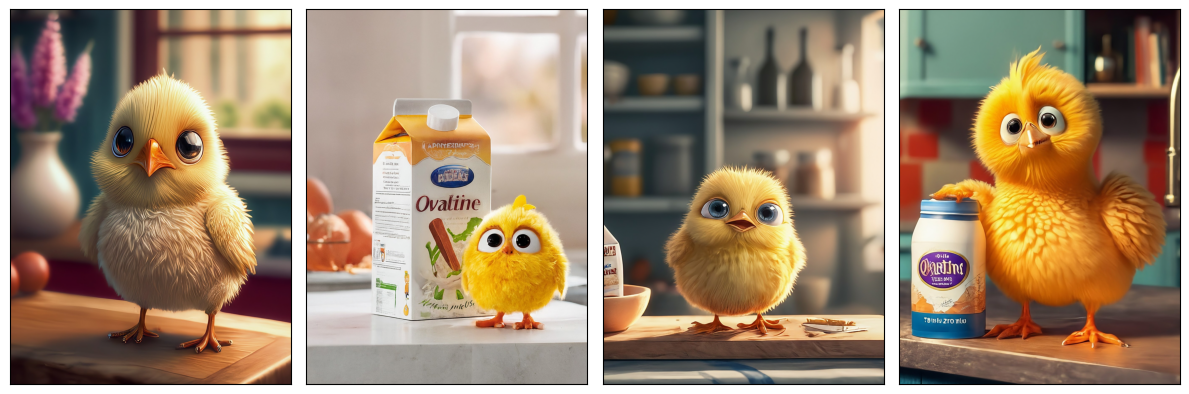


 Advertisement text in Thai: 
 อาบแดดพร้อมดื่มนมยูเอชที เวอร์ชั่นเครื่องดื่มสำหรับผู้ใหญ่ในกล่องน้ำผลไม้ แต่ไม่มีหลอดเล็กๆ และตัวการ์ตูน 
-----------------------------------------------------

 Generating advertisement for Tea&Coffee ลิปตันแบล็คทีเลมอน 445ml, in SUNNY weather, for ADULT FEMALE, in CENTER of Thailand

 Mascot action image prompt: 
            describe action of main character of Tea or Tea&Coffee advertisement 
            to make female customer , age 25-40 years old, 
            want to buy it in 1 sentence. I need only description of the action.
        
Mascot action image prompt output: 
 Witha knowing smile, the barista crafts a beautiful latte art design, showcasing the rich, creamy texture of the beverage.

 Final image prompt for advertisement image: 
 ##Image Prompt Options:

**Option 1 (Focus on Humor):*** **Style:** Pixar cartoon style
* **Subject:** A fluffy yellow chick, with a knowing smile, behind a coffee bar, holding a cup of tea with the Lipton logo

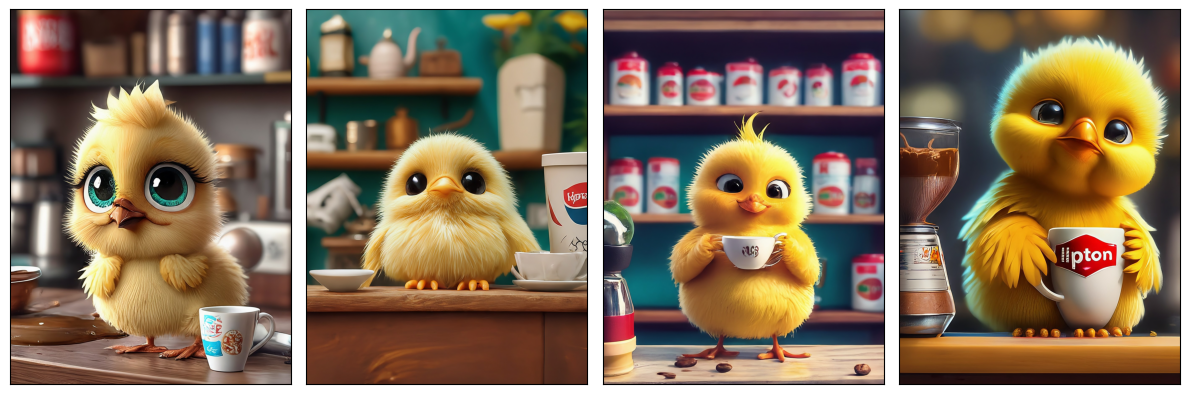


 Advertisement text in Thai: 
 รู้สึกเหมือนต้นไม้เหี่ยวเฉา คว้า มาจิบแล้วอาบแดดหน่อย เดี๋ยวก็ผลิบานในพริบตา 
-----------------------------------------------------

 Generating advertisement for Moisturizer For Body จอห์นสันเบบี้โลชั่น 100ml, in SUNNY weather, for ADULT FEMALE, in CENTER of Thailand

 Mascot action image prompt: 
            describe action of main character of Basic Care or Moisturizer For Body advertisement 
            to make female customer , age 25-40 years old, 
            want to buy it in 1 sentence. I need only description of the action.
        
Mascot action image prompt output: 
 Awoman luxuriates in the feeling of soft, supple skin after applying the body moisturizer, running her hands along her arm with a satisfied smile.

 Final image prompt for advertisement image: 
 ##Image Prompt Options:

Here are a few options for rewriting the prompt in thestyle of a Pixar cartoon, removing the human element and focusing on humor, withbranding subtly incorporated

In [ ]:
main()